In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.3 MB 11.9 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [4]:
import mlxtend                                                        
print(mlxtend.__version__) 

0.19.0


In [5]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 10.4 MB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 895 kB 49.8 MB/s 
     |████████████████████████████████| 596 kB 45.0 MB/s 
     |████████████████████████████████| 6.8 MB 35.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 9.6 MB/s 


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import transformers

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import string
import re
import io
from nltk.tokenize import sent_tokenize
from collections import Counter


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
plt.style.use('seaborn')

from transformers import TFXLNetModel, XLNetTokenizer
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [10]:
######################## read data ################################
eec_data = np.load('/content/drive/MyDrive/data/eec/eec_data.npy')
eec_labels = np.load('/content/drive/MyDrive/data/eec/eec_label.npy')

In [12]:
eec_data[1:6]

array(['Alonzo feels furious.', 'Alonzo feels irritated.',
       'Alonzo feels enraged.', 'Alonzo feels annoyed.',
       'Alonzo feels sad.'], dtype='<U100')

In [13]:
print("--------------EEC Shapes-----------")
print("EEC data: ", eec_data.shape)
print("EEC labels: ", eec_labels.shape)
print("\n")

--------------EEC Shapes-----------
EEC data:  (8400,)
EEC labels:  (8400, 1)




In [14]:
def pre_processing(data):
  Tokens = []
  finalTokens =[]
  tokenizer = RegexpTokenizer(r'\w+')
  stop_words = set(stopwords.words('english')) 
  for i in range(len(data)):
    tempTokens = data[i].lower() #converting to lower case
    tempTokens = tempTokens.translate(str.maketrans('','',"~!@#$%^&*()_-+={}[]|\/><'?.,-+`:;1234567890"))
    tempTokens = tokenizer.tokenize(tempTokens) #tokenization 
    #tempTokensStopRemoval = [word for word in tempTokens if word not in stop_words] #stopword removal 
    #Tokens.append(tempTokens) # tokens with out stopword removal 
    finalTokens.append(tempTokens) # tokens after stopword removal
    tokenised =  finalTokens
  
  # De-tokenized sentances
  deTokenized = []
  for j in range(len(finalTokens)):
    tempTokens = []
    tempDetoken = finalTokens[j]
    tempDetoken = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tempDetoken]).strip()
    deTokenized.append(tempDetoken)

  return deTokenized


In [15]:
########################## EEC data and label pre-processing #######################
eec_data_final = pre_processing(eec_data)
eec_labels_final = to_categorical(eec_labels,num_classes=4)

In [16]:
def get_inputs(tweets, tokenizer, max_len=20):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

In [17]:
# This is the identifier of the model. The library need this ID to download the weights and initialize the architecture
# here is all the supported ones:
# https://huggingface.co/transformers/pretrained_models.html
xlnet_model = 'xlnet-large-cased' #xlnet-base-cased-spiece.model, xlnet-large-cased
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/761 [00:00<?, ?B/s]

In [18]:
x_eec_tokens, x_eec_ids, x_eec_segments = get_inputs(eec_data_final, xlnet_tokenizer)
print("train token shape:" +str(x_eec_tokens.shape))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


train token shape:(8400, 20)


In [19]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(20,), name='word_inputs', dtype='int32')

    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    #doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss=CategoricalCrossentropy(from_logits = True), metrics=CategoricalAccuracy('balanced_accuracy'))

    return model

In [38]:
best_model = create_xlnet(xlnet_model)
best_model.load_weights('/content/drive/MyDrive/model/best/xlnet_BEST_1_lr00001_epoch30_noDropout_bsize64_softmax_monitorAcc_fusedData.h5')
predict_eec = best_model.predict(x_eec_tokens)

Some layers from the model checkpoint at xlnet-large-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-large-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init_

In [39]:
y_predicted = np.argmax(predict_eec, axis = 1)
predict_intensity = np.amax(predict_eec, axis = 1)

In [40]:
print(predict_eec[0:10])
print(predict_intensity[0:10])

[[9.3367410e-01 1.3967165e-02 9.9633972e-04 5.1362444e-02]
 [9.8325861e-01 5.7397503e-03 4.6080799e-04 1.0540900e-02]
 [4.9612555e-01 1.3711554e-01 1.5804436e-02 3.5095453e-01]
 [9.6443486e-01 9.7402046e-03 5.3482200e-04 2.5290066e-02]
 [4.1230699e-01 1.0211330e-01 1.8638456e-02 4.6694121e-01]
 [9.3880873e-03 1.9713201e-02 1.0614706e-02 9.6028399e-01]
 [1.4028690e-02 3.0199969e-02 5.9867096e-03 9.4978464e-01]
 [3.4365434e-02 7.6752134e-02 9.5576635e-03 8.7932485e-01]
 [3.0759612e-02 1.0757783e-01 1.0451179e-02 8.5121137e-01]
 [5.1759440e-02 3.3904549e-02 1.7662622e-02 8.9667344e-01]]
[0.9336741  0.9832586  0.49612555 0.96443486 0.4669412  0.960284
 0.94978464 0.87932485 0.85121137 0.89667344]


In [41]:
temp = np.hstack((np.reshape(eec_data,(len(eec_data),1)),np.reshape(y_predicted,(len(y_predicted),1))))
eec_prediction2csv = np.hstack((temp,np.reshape(predict_intensity,(len(predict_intensity),1))))

In [42]:
eec_prediction2csv[0:10]

array([['Alonzo feels angry.', '0', '0.9336741'],
       ['Alonzo feels furious.', '0', '0.9832586'],
       ['Alonzo feels irritated.', '0', '0.49612555'],
       ['Alonzo feels enraged.', '0', '0.96443486'],
       ['Alonzo feels annoyed.', '3', '0.4669412'],
       ['Alonzo feels sad.', '3', '0.960284'],
       ['Alonzo feels depressed.', '3', '0.94978464'],
       ['Alonzo feels devastated.', '3', '0.87932485'],
       ['Alonzo feels miserable.', '3', '0.85121137'],
       ['Alonzo feels disappointed.', '3', '0.89667344']], dtype='<U100')

In [43]:
# convert array into dataframe
tempDF = pd.DataFrame(eec_prediction2csv)
tempDF.to_csv("/content/drive/MyDrive/data/eec_predictions/XLNet_eec_predictions.csv")

In [44]:

class_names=['anger', 'fear', 'joy', 'sadness']
print(classification_report(np.int32(eec_labels), y_predicted,target_names=class_names))

              precision    recall  f1-score   support

       anger       1.00      0.73      0.84      2100
        fear       0.90      0.84      0.87      2100
         joy       0.91      0.99      0.95      2100
     sadness       0.78      0.98      0.87      2100

    accuracy                           0.89      8400
   macro avg       0.90      0.89      0.88      8400
weighted avg       0.90      0.89      0.88      8400



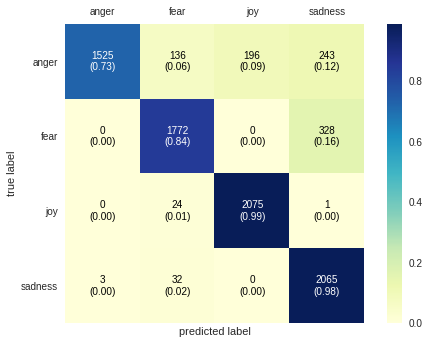

In [45]:
cm = confusion_matrix(y_target=np.int32(eec_labels), y_predicted=np.reshape(y_predicted,(len(y_predicted),1)), binary=False)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                cmap="YlGnBu",
                                colorbar=True,
                                class_names=class_names)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,rotation=0)
plt.yticks(tick_marks, class_names)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('top')